<a href="https://colab.research.google.com/github/feynmanm/board_game_concierge/blob/main/bg_concierge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Board Game Concierge: Answering Questions for Complex Board Games  
## Fine-tuning DistilBERT Question-Answering on an unsupervised, small-domain corpus.  

In the realm of complex board games, rules questions abound. A tool that simply answers a player's rules questions would be helpful. An NLP solution applied to this problem may be able to take advantage of a special circumstance of this realm to avoid labeling game rules for the question-answering task --> Questions themselves will only be asked of the exact text corpus that the fine-tuned model would be trained on. And, thusly, overfitting on the training corpus is good.

 

## Overview
This notebook presents the preprocessing, training, and inference algorithm of the Board Game Concierge reference aid. We demonstrate it with the 25k+-word game rules of the complex board game High Frontier 4 All (base game). 
> High Frontier 4 All Core Rules   
Copyright &copy; 2020 Ion Game Design & Sierra Madre Games  
Lead Designer: Phil Eklund  

We utilize our own flavor of domain adaptation so that the rules need not be labelled. The key is fine tuning the contextualized representation of the English language of the well-known vanilla DistilBERT model on our game rules corpus, then freezing the early encoders, and then retraining the model for question answering on the off-the-shelf SQuAD v1 corpus. The resulting QA model contains particular knowledge of the game rules while being fully trained to process English-language questions.

During inference, the user asks a question. We utilize staCy to identify appropriate passages from the game rules that might contain an answer to the question, then ask the question of each such passage, and return the answer(s) with the highest confidence scores. spaCy also plays an interesting role in addressing some preprocessing challenges specific to the rules of High Frontier 4 All.

In [ ]:
# Need huggingface's transformers and datasets
!pip install transformers datasets 

In [ ]:
import os
import pandas as pd
from google.colab import files
import re
import spacy
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForQuestionAnswering
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling, default_data_collator
from transformers import pipeline
from datasets import load_dataset

##Preprocessing Game Rules Text

The first step to implementing the concierge for a new board game is preprocessing the rules text. The exact steps vary greatly depending on the starting qualities of the individual rules and the desired ending quality (i.e., effectiveness for training). Generally, we want to remove flavor text and build long passages (less than 512 tokens) of cohesive rules text as training examples.  

In this notebook, we process the game rules for High Frontier 4 All  

> High Frontier 4 All Core Rules   
Copyright &copy; 2020 Ion Game Design & Sierra Madre Games  
Lead Designer: Phil Eklund

I intended to clean all the data in python, but threw in the towel and performed the following big & easy tasks in Notepad++...  
* Removed title and document opening text
* Removed end credits
* Removed hyphens from words broken at new lines.  
* Replaced curly quotes (opening and closing) with straight ones.
* Removed a handful of sidebar titles with no further text
* Fixed multiple occurances of this mispelling: IRSU --> ISRU
* Removed several new lines that served no purpose and followed no pattern (artifacts of pdf export to text?)
* Removed footnotes #3, #17, #42, #45, #47 because they contained arbitrary new lines
* Removed the "Scale" entry from glossary (quite lengthy and all flavor... but fascinating).
* Made certain each glossary entry began with the entry name and period.
* Encoded doc as UTF-8.  

The following is performed in python (below)...  
* Remove footnotes (all flavor text).
* Remove footnote citations.
* Replace tabs with spaces
* Remove excess spaces
* Remove excess new lines (some are artifacts from pdf export to text?)
* Merge headers (i.e. paragraphs with no verbs... as detected by spaCy) into the paragrahs that follow them
* Remove extraneous inter-document references







In [ ]:
# If running from a github repo clone, you don't need to run this cell as the rules file is already in the correct location
! cp "drive/MyDrive/highfrontier_rules/rules/HF4CoreRules_utf8.txt" .

In [ ]:
# Start working on the core rules, observe first hundred characters

with open(r'HF4CoreRules_utf8.txt', 'r') as f:
  f = f.read()

f[:100]

'A. Introduction\nThese Core rules (including the glossary at the end) comprise the base game, and are'

In [ ]:
# Take a look at footnotes using regular expressions. We remove them next in the next cell.

p_footnote = re.compile(r"""
    ([0-9]+)\1                   # pair of back-to-back footnote indices (i.e., doubled up combination of digits)
    \s?                          # optional space before footnote title
    [A-Z]{2,}[-|,|.|\b]?\s?      # first word of title, i.e., a 2+-letter, all-cap word followed by an optional separator plus an optional space
    .+                           # text up to new line
""", re.VERBOSE)
footnotes = p_footnote.finditer(f)

for note in [n for n in footnotes][:10]:
  print(note.group())
  print(note.span())

# By adjusting the slice of the footnotes iterable, we can print all 55 of them, minus those removed in notepad++ as described above, looks good!
# Note: A couple footnotes contain a little bit of legit rules text before the new line is reached, which is lost.

11 WATER, THE KEY TO THE SOLAR SYSTEM. No place in space has resource value without a local supply of water, primarily for rocket propellant and "exofuels", but also for chemical and mineralogical processing, dust control, crops, and life support. Water is a storable and convenient source of hydrogen, the superior propellant for thermodynamic rockets. Water is a natural shield against energetic protons, kilo for kilo better than regolith or even metals. Finally, without recycling, each man-year requires 10 tonnes of water. (Although it is worth noting that human metabolisms convert carbohydrates plus oxygen into carbon dioxide and water, thus we are stoichiometrically net producers rather than consumers of water.) 
(841, 1565)
22 WATER AVAILABILITY is greatest on worlds with icy cores, where simply injecting steam into a wellhole produces water. On drier worlds, where water only occurs as tiny ice crystals or hydrated silicates, the regolith would need to be crushed, sealed in a vessel

In [ ]:
# Delete footnotes

print('BEFORE REMOVING FOOTNOTES:\n', f[800:2000], '\n\n')
f_defoot = p_footnote.sub(' ', f)
print('AFTER REMOVING FOOTNOTES:\n', f_defoot[800:1300])

# Now we see a footnote citation ("- Glenn Macpherson,...") that would be easy enough to isolate and remove with RE

BEFORE REMOVING FOOTNOTES:
 as money ("Aqua") if shipped back to LEO.11 WATER, THE KEY TO THE SOLAR SYSTEM. No place in space has resource value without a local supply of water, primarily for rocket propellant and "exofuels", but also for chemical and mineralogical processing, dust control, crops, and life support. Water is a storable and convenient source of hydrogen, the superior propellant for thermodynamic rockets. Water is a natural shield against energetic protons, kilo for kilo better than regolith or even metals. Finally, without recycling, each man-year requires 10 tonnes of water. (Although it is worth noting that human metabolisms convert carbohydrates plus oxygen into carbon dioxide and water, thus we are stoichiometrically net producers rather than consumers of water.) 
— Glenn MacPherson, Oxygen in the Solar System, Lunar & Planetary Institute, 2008. 
 
a.	Core Game Victory. At the end of 48 years (48 Turns per player), the winner is the player with the highest victory po

In [ ]:
# Isolate footnote citations and observe

p_citation = re.compile(r"""
    —        # big dash [I think n- and m-dashes both converted to this thing during upload]
    \s?      # optional space
    .+?      # text (non-greedily) up to next required element (comma)
    ,        # comma
    .+       # text up to new line
""", re.VERBOSE)

citations = p_citation.finditer(f_defoot)

for cite in citations:
  print(cite.group())
  print(cite.span())

# 5 citations found

— Glenn MacPherson, Oxygen in the Solar System, Lunar & Planetary Institute, 2008. 
(843, 926)
—Namrata Goswami, China’s grand strategy in outer space: to establish compelling standards of behavior, 2019.
(35099, 35208)
—Ruslan Belikov, NASA Ames, personal communication, 2020.
(43632, 43689)
—Hepp, Landis, Kubiak, Carbon Dioxide Utilization on Mars, 1993.
(52933, 52997)
—JED Cline, The Mooncable: A Profitable Space Transportation System, 1972.
(93992, 94066)


In [ ]:
# Delete footnote citations

print('BEFORE REMOVING CITATIONS:\n', f_defoot[800:1000], '\n\n')
f_defoot = p_citation.sub(' ', f_defoot)
print('AFTER REMOVING CITATIONS:\n', f_defoot[800:1000])

BEFORE REMOVING CITATIONS:
 as money ("Aqua") if shipped back to LEO. 
— Glenn MacPherson, Oxygen in the Solar System, Lunar & Planetary Institute, 2008. 
 
a.	Core Game Victory. At the end of 48 years (48 Turns per player), the 


AFTER REMOVING CITATIONS:
 as money ("Aqua") if shipped back to LEO. 
 
 
a.	Core Game Victory. At the end of 48 years (48 Turns per player), the winner is the player with the highest victory point (VP) total. 
b.	Sunspot Cycle


In [ ]:
# Replace tabs with spaces
f_defoot = f_defoot.replace('\t', ' ')

# Remove excess spaces
f_defoot = re.sub(' {2,}', ' ', f_defoot)

# Remove excess new lines
f_defoot = re.sub('\n{2,}', '\n', f_defoot)

# Replace space + new line + space with space (fixing artifact of export from pdf)
f_defoot = re.sub(' \n ', ' ', f_defoot)

In [ ]:
"""
This cell is a little tool for manually pasting in a string, and returning how spaCy identifies the parts of speech therein
"""

string_to_parse = 'B5. Solar System Charts'

pos = spacy.load('en_core_web_sm')
doc = pos(string_to_parse)
for token in doc:
  print(token.text, '-->', token.pos_, token.tag_)

# We note that spaCy incorrectly identifies 'Charts' in 'B5. Solar System Charts' as a verb. 
# This is understandable and of trivial consequence to us as it occurs infrequently. 

B5 --> PROPN NNP
. --> PUNCT .
Solar --> ADJ JJ
System --> NOUN NN
Charts --> VERB VBZ


In [ ]:
"""
Merge Headers
Append each header (i.e., each paragraph with no verb) to the paragraph in front of it.
Use the spaCy nlp model 'en_core_web_sm' to determine if a given paragraph has a verb or not.

NOTE: Paragraphs in game rules tend to be shorter than in normal prose.
We call everything between hard returns 'paragraphs'... even if it most are single sentences.
"""

def contains_verb(string, spacy_model):
  tokens = spacy_model(string)
  for t in tokens:
    if (t.pos_, t.tag_) in [
                             ('AUX', 'VBD'),
                             ('AUX', 'VBP'),
                             ('AUX', 'VBZ'),
                             ('AUX', 'VB'),
                             ('VERB', 'VBP'),
                             ('VERB', 'VBD'),
                             ('VERB', 'VBZ'),
                             ('VERB', 'VB'),
                           ]:
      return True
  return False

spacy_model = spacy.load('en_core_web_sm')

# split the corpus into a list of paragrphs
paragraphs = f_defoot.split('\n')

f_headsMerged = []       # This is the corpus updated with merged headers
headers = []             # This list is just the headers, shows us what is being identified as such
header = ''
for p in paragraphs:
  if contains_verb(p, spacy_model):
    f_headsMerged.append(header + p)
    header = ''
  else:
    p = p.strip('.: ') + '. '    # clean up headers (stnadardize with trailing period and space)
    headers.append(p)
    header = header + p     # Note: Adjacent header paragraphs are concantenated into a single header

print('Original paragraph count:', len(paragraphs), '\nAfter merging headers:', len(f_headsMerged), '\n')
for h in headers[:20]:
  print(h)

# Investigating the entire headers list reveals a half dozen or so paragraphs with verbs that spaCy incorrectly identified as having no verbs.
# The purpose of merging headers is to simply partner the great majority of disparate headers with an associated paragrphs to facilitate training.
# A few paragraph pairs grouped into a single paragraph is not a problem (particularly how the one with no identified verbs will likely be short).

Original paragraph count: 1060 
After merging headers: 809 

A. Introduction. 
A1. Core Overview. 
. 
A2. Metarules. 
EXAMPLE [A2a]. 
A3. Introductory Games. 
B. Components & Anatomies. 
B1. Component List. 
B2. Patent Cards. 
( J3a). 
j. Rad-Hardness. Resistance to solar flares ( K2d), and Radiation Belts ( H10). 
B3. Glory & Heroism Chits. 
B4. Playmats. 
B6. Crew Cards. 
b. Faction Ideology. (Module 0). Used for placing delegates (O2c). 
B7. Solar System Map. 
B8. Tokens. 
C. Core Setup. 
C1. Seniority Disk Placement. 
C2. Assign Factions & Crew. 


In [ ]:
"""
We can see how headers are prepended to paragraphs.
Of course, not every paragraph with a verb is preceded by a header.
"""

f_headsMerged[290:310]

# Looking at the first 40 lines of f_headsMerged, we can see an error from spaCy POS where a noun is incorrectly
# identified as a verb (Charts in 'B5. Solar System Charts'), thus an actual header is not merged with the parapraph following it.
# Occasional errors like this are probably not worth fixing.

['b. Selling Black-Side Card From LEO Stack. Discard a Black-Side card located in your Bank (see glossary) to your Hand. Receive Aquas equal to the factory stock price listed on the Exploitation Track (B5) for that card’s Spectral Type (letter on the card: C, S, M, V, D, or H). Thus, a Black-Side card could be worth 4, 5, or 8 Aquas. If there are no Factories of a Spectral Type (e.g. the last cube is retired per I7f), then it is worth 10 Aquas.',
 ' • Radiators are sold for the same price regardless of Orientation (see glossary).',
 ' • Any. Cards that are of Spectral Type "ANY" can be ET produced at any Factory but cannot be sold.',
 'EXAMPLE [I3b]. You have ET produced a Black-Side card of Spectral Type C. You can move it to LEO and sell it to your Hand for 4 to 8 Aquas, or you can Decommission it and sell it from your Hand for 3 Aquas. Since Spectral Type C is currently at value 8, you choose to move it and sell it at LEO. ',
 'I4. Boost Operation. Bring one or more Hand cards into 

(array([16., 37., 64., 97., 78., 67., 75., 56., 61., 41., 38., 36., 29.,
        25., 13., 20.,  8.,  8.,  7.,  5.,  3.,  7.,  6.,  4.,  0.,  1.,
         2.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  13.  ,   38.08,   63.16,   88.24,  113.32,  138.4 ,  163.48,
         188.56,  213.64,  238.72,  263.8 ,  288.88,  313.96,  339.04,
         364.12,  389.2 ,  414.28,  439.36,  464.44,  489.52,  514.6 ,
         539.68,  564.76,  589.84,  614.92,  640.  ,  665.08,  690.16,
         715.24,  740.32,  765.4 ,  790.48,  815.56,  840.64,  865.72,
         890.8 ,  915.88,  940.96,  966.04,  991.12, 1016.2 , 1041.28,
        1066.36, 1091.44, 1116.52, 1141.6 , 1166.68, 1191.76, 1216.84,
        1241.92, 1267.  ]),
 <a list of 50 Patch objects>)

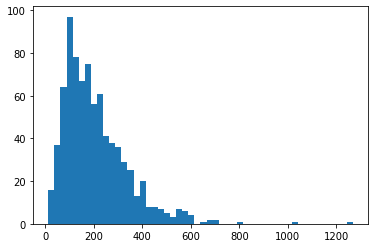

In [ ]:
"""
Sanity check, look at distribution of paragraph sizes.
"""

lengths = [len(p) for p in f_headsMerged]
plt.hist(lengths, bins=50)

# Looks like majority of paragraphs in f_headsMerged have between 60 and 350 characters with max at 1300. Should all tokenize to less than 512 word-part tokens.

In [ ]:
"""
Tokenize our rules paragraphs.
We will work with DistilBERT models all using the same tokenizer checkpoint 'distilbert-base-uncased'.
"""

tokenizer_checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(tokenizer_checkpoint, use_fast=True)
tokenized_data = tokenizer(f_headsMerged)
len(tokenized_data['input_ids'])

# Sanity check, there are 809 lists of input_ids, one per paragraph, this checks out.

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

809

(array([ 22.,  47.,  68., 111.,  81.,  80.,  59.,  67.,  54.,  37.,  36.,
         30.,  23.,  21.,  10.,  17.,  10.,   6.,   8.,   6.,   1.,   1.,
          2.,   7.,   0.,   1.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([  7.  ,  13.56,  20.12,  26.68,  33.24,  39.8 ,  46.36,  52.92,
         59.48,  66.04,  72.6 ,  79.16,  85.72,  92.28,  98.84, 105.4 ,
        111.96, 118.52, 125.08, 131.64, 138.2 , 144.76, 151.32, 157.88,
        164.44, 171.  , 177.56, 184.12, 190.68, 197.24, 203.8 , 210.36,
        216.92, 223.48, 230.04, 236.6 , 243.16, 249.72, 256.28, 262.84,
        269.4 , 275.96, 282.52, 289.08, 295.64, 302.2 , 308.76, 315.32,
        321.88, 328.44, 335.  ]),
 <a list of 50 Patch objects>)

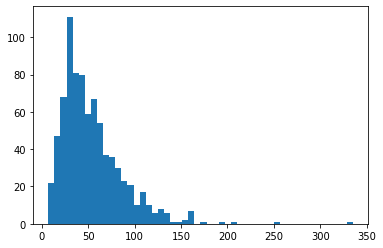

In [ ]:
"""
Sanity check, look at distribution of of token counts in paragraphs.
"""

lenths_tokens = [len(p_tokenized) for p_tokenized in tokenized_data['input_ids']]
plt.hist(lenths_tokens, bins=50)

# We see paragraphs lengths go up to 350'ish tokens, with median around 50.
# Our transformers models can take inputs of length 512.
# We'll train both with single paragraphs inputs as combining parapraphs to create longer inputs.

# of inputs when paragraphs are combined: 92


(array([2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 3., 0., 3., 1., 1., 5.,
        4., 1., 2., 6., 3., 4., 4., 6., 3., 5., 7., 2., 6., 3., 6., 8.]),
 array([355.  , 358.14, 361.28, 364.42, 367.56, 370.7 , 373.84, 376.98,
        380.12, 383.26, 386.4 , 389.54, 392.68, 395.82, 398.96, 402.1 ,
        405.24, 408.38, 411.52, 414.66, 417.8 , 420.94, 424.08, 427.22,
        430.36, 433.5 , 436.64, 439.78, 442.92, 446.06, 449.2 , 452.34,
        455.48, 458.62, 461.76, 464.9 , 468.04, 471.18, 474.32, 477.46,
        480.6 , 483.74, 486.88, 490.02, 493.16, 496.3 , 499.44, 502.58,
        505.72, 508.86, 512.  ]),
 <a list of 50 Patch objects>)

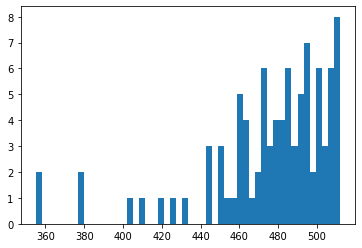

In [ ]:
"""
Combine paragraphs into longer inputs (but not longer than 512 tokens).
We'll train on both single-paragraph inputs and combined-paragraph inputs, 
and then compare performance on a few sample masked language tasks (directly from the training corpus).
"""

tokenized_data_combined = []
new_input = []
for p in tokenized_data['input_ids']:
  if len(p) + len(new_input) > 512:
    tokenized_data_combined.append(new_input)
    new_input = []
  new_input += p

print('# of inputs when paragraphs are combined:', len(tokenized_data_combined))

lengths_tokens = [len(combo_p) for combo_p in tokenized_data_combined]
plt.hist(lengths_tokens, bins=50)

# Note: we incidentally are not training on the final paragraph from tokenized_data. 
# It's inclusion is trivial, but it is likely to be significantly shorter than the other 92 inputs.
# Looks good, great majority of combined inputs have > 450 tokens

## Fine-Tuning DistilBERT Encoders

In [ ]:
"""
We make three masked LM models all from the same starting point, vanilla DistilBERT.
1) Our untuned model for benchmarking progress
2) A version fine-tuned on single-paragraph inputs
3) A version fine-tuned on combo-paragraph inputs
For the fine tuning, we freeze the first 2 encoders (i.e., make them not trainable)
and fine tune the remaining 4 encoders to contextualilze the language on the game rules
"""

untuned_maskedLM = AutoModelForMaskedLM.from_pretrained(tokenizer_checkpoint)
maskedLM_for_singleInputs = AutoModelForMaskedLM.from_pretrained(tokenizer_checkpoint)
maskedLM_for_comboInputs = AutoModelForMaskedLM.from_pretrained(tokenizer_checkpoint)

for p in [param for param in maskedLM_for_singleInputs.base_model.parameters()][:-64]:
  p.requires_grad = False

for p in [param for param in maskedLM_for_comboInputs.base_model.parameters()][:-64]:
  p.requires_grad = False

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.15.0",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a

In [ ]:
count = 0
for name, param in maskedLM_for_comboInputs.named_parameters():
  print ('Trainable?', param.requires_grad, '-->', name)
  count += 1

print(count, 'layers')

Trainable? False --> distilbert.embeddings.word_embeddings.weight
Trainable? False --> distilbert.embeddings.position_embeddings.weight
Trainable? False --> distilbert.embeddings.LayerNorm.weight
Trainable? False --> distilbert.embeddings.LayerNorm.bias
Trainable? False --> distilbert.transformer.layer.0.attention.q_lin.weight
Trainable? False --> distilbert.transformer.layer.0.attention.q_lin.bias
Trainable? False --> distilbert.transformer.layer.0.attention.k_lin.weight
Trainable? False --> distilbert.transformer.layer.0.attention.k_lin.bias
Trainable? False --> distilbert.transformer.layer.0.attention.v_lin.weight
Trainable? False --> distilbert.transformer.layer.0.attention.v_lin.bias
Trainable? False --> distilbert.transformer.layer.0.attention.out_lin.weight
Trainable? False --> distilbert.transformer.layer.0.attention.out_lin.bias
Trainable? False --> distilbert.transformer.layer.0.sa_layer_norm.weight
Trainable? False --> distilbert.transformer.layer.0.sa_layer_norm.bias
Traina

In [ ]:
"""
ESTABLISH BENCHMARK
Run a set of highly technical game rules paragraphs with a masked token through vanilla DistilBERT MaskedLM before fine-tuning. 
Note the top 5 suggestions and confidence scores; we will run the same paragraphs through after fine-tuning the model on the game rules.
"""

# answer1 = 'spacecraft'
para1 = 'The dry mass chit is a token on the fuel strip indicating the mass of a [MASK], not counting its fuel.'

# answer2 = 'heavy'
para2 = 'A radiator card played in its [MASK] Orientation rotates to its light Orientation instead of being involuntarily decommissioned upon failing Glitch Rolls, Hazard Rolls, or Belt Rolls.'

# answer3 = 'triangle'
para3 = 'Performing a Burn expends a number of fuel steps (not tanks) equal to the fuel consumption of the activated thrust [MASK].'

# answer4 = 'mass'
para4 = 'A Spacecraft may use factory-assist to enter one lander burn (paying the lander burn cost) from an Atmospheric Site without needing a thrust greater than the Site Size by expending a special water cost using FTs at the Site. This water cost, which is expended without adding to the Spacecraft’s Wet or Dry Mass, is equal to a number of blue FTs equal to twice the initial Wet [MASK] of the Spacecraft. Then continue movement, treating lander burns as burns that you cannot halt on. This represents winged boosters using fuels manufactured directly from the atmosphere.'

# answer5 = 'lowering'
para5 = '3. This increases the Rocket’s weight class, which lowers its net thrust by one. If instead factory-refuel is used (i5b), it gains up to 7 tanks, moving the chit to 11 and [MASK] its net thrust by two.'

untuned_maskedLM_pipe = pipeline('fill-mask', model=untuned_maskedLM, tokenizer=tokenizer)
print(untuned_maskedLM_pipe(para1))
print(untuned_maskedLM_pipe(para2))
print(untuned_maskedLM_pipe(para3))
print(untuned_maskedLM_pipe(para4))
print(untuned_maskedLM_pipe(para5))

# We observe:
# suggested answer1's: 'vehicle' (48%), 'spacecraft' [CORRECT ANSWER] (6%), 'tank' (5%), 'fuel' (4%), 'rocket' (3%) ... got the right answer, but with 6% confidence
# suggested answer2's: 'light' (5%), 'dark' (5%), 'reverse' (3%), 'normal' (3%), 'vertical' (2%)
# suggested answer3's: 'thrusters' (14%), 'thruster' (12%), 'thrust pump' (8%), 'thrust engine' (6%), 'thrust tank' (4%)
# suggested answer4's: 'mass' (96%) [CORRECT ANSWER]... OTS QA nailed this one!
# suggested answer5's: 'increasing' (30%), 'decreasing' (23%), 'lowering' (18%) [CORRECT ANSWER], 'reducing' (13%), 'increases' (2%)
# On this last one, note how well the OTS QA identifies appropriate verb forms

[{'score': 0.48114946484565735, 'token': 4316, 'token_str': 'vehicle', 'sequence': 'the dry mass chit is a token on the fuel strip indicating the mass of a vehicle, not counting its fuel.'}, {'score': 0.06393490731716156, 'token': 12076, 'token_str': 'spacecraft', 'sequence': 'the dry mass chit is a token on the fuel strip indicating the mass of a spacecraft, not counting its fuel.'}, {'score': 0.05208604782819748, 'token': 4951, 'token_str': 'tank', 'sequence': 'the dry mass chit is a token on the fuel strip indicating the mass of a tank, not counting its fuel.'}, {'score': 0.03590632602572441, 'token': 4762, 'token_str': 'fuel', 'sequence': 'the dry mass chit is a token on the fuel strip indicating the mass of a fuel, not counting its fuel.'}, {'score': 0.030259234830737114, 'token': 7596, 'token_str': 'rocket', 'sequence': 'the dry mass chit is a token on the fuel strip indicating the mass of a rocket, not counting its fuel.'}]
[{'score': 0.053331658244132996, 'token': 2422, 'token_

In [ ]:
"""
SET UP MODEL
We want to compare single-paragraph inputs to combined-paragraph inputs (and to vanilla DistilBERT).
Training set is small, seems to converge after 128 or so epochs.
"""

collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

training_args_singleInputs = TrainingArguments(
    output_dir = 'finetuned_output_singleInputs',
    save_strategy = 'steps',
    save_steps = 500,
    num_train_epochs = 256,
    per_device_train_batch_size = 16
)

trainer_singleInputs = Trainer(
    model = maskedLM_for_singleInputs,
    args = training_args_singleInputs,
    train_dataset = tokenized_data['input_ids'],
    data_collator = collator
)

training_args_comboInputs = TrainingArguments(
    output_dir = 'finetuned_output_comboInputs',
    save_strategy = 'steps',
    save_steps = 500,
    num_train_epochs = 512,
    per_device_train_batch_size = 16
)

trainer_comboInputs = Trainer(
    model = maskedLM_for_comboInputs,
    args = training_args_comboInputs,
    train_dataset = tokenized_data_combined,
    data_collator = collator
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
"""
TRAIN MODEL on single-paragraph inputs
This took me about 8 minutes on the Colab Pro GPU runtime.
"""

trainer_singleInputs.train()
trainer_singleInputs.save_model('mlm_tuned_singleInputs')

***** Running training *****
  Num examples = 809
  Num Epochs = 256
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 13056


Step,Training Loss
500,2.306800
1000,1.650700
1500,1.337100
2000,1.084600
2500,0.918800
3000,0.799100
3500,0.702400
4000,0.606000
4500,0.559900
5000,0.513800


Saving model checkpoint to finetuned_output_singleInputs/checkpoint-500
Configuration saved in finetuned_output_singleInputs/checkpoint-500/config.json
Model weights saved in finetuned_output_singleInputs/checkpoint-500/pytorch_model.bin
Saving model checkpoint to finetuned_output_singleInputs/checkpoint-1000
Configuration saved in finetuned_output_singleInputs/checkpoint-1000/config.json
Model weights saved in finetuned_output_singleInputs/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to finetuned_output_singleInputs/checkpoint-1500
Configuration saved in finetuned_output_singleInputs/checkpoint-1500/config.json
Model weights saved in finetuned_output_singleInputs/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to finetuned_output_singleInputs/checkpoint-2000
Configuration saved in finetuned_output_singleInputs/checkpoint-2000/config.json
Model weights saved in finetuned_output_singleInputs/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to finetuned_ou

In [ ]:
"""
TRAIN MODEL on combined-paragraph inputs
This took me about 8 minutes on the Colab Pro GPU runtime.
"""

trainer_comboInputs.train()
trainer_comboInputs.save_model('mlm_tuned_comboInputs')

***** Running training *****
  Num examples = 92
  Num Epochs = 512
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3072


Step,Training Loss
500,1.709600
1000,0.883600
1500,0.595200
2000,0.462500
2500,0.391200
3000,0.357000


Saving model checkpoint to finetuned_output_comboInputs/checkpoint-500
Configuration saved in finetuned_output_comboInputs/checkpoint-500/config.json
Model weights saved in finetuned_output_comboInputs/checkpoint-500/pytorch_model.bin
Saving model checkpoint to finetuned_output_comboInputs/checkpoint-1000
Configuration saved in finetuned_output_comboInputs/checkpoint-1000/config.json
Model weights saved in finetuned_output_comboInputs/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to finetuned_output_comboInputs/checkpoint-1500
Configuration saved in finetuned_output_comboInputs/checkpoint-1500/config.json
Model weights saved in finetuned_output_comboInputs/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to finetuned_output_comboInputs/checkpoint-2000
Configuration saved in finetuned_output_comboInputs/checkpoint-2000/config.json
Model weights saved in finetuned_output_comboInputs/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to finetuned_output_comboIn

In [ ]:
"""
Make models with each of the newly-trained fine-tuned weights.
We also need to rebuild the OTS model as 
"""
tuned_model_singleInputs = AutoModelForMaskedLM.from_pretrained('mlm_tuned_singleInputs')
tuned_model_comboInputs = AutoModelForMaskedLM.from_pretrained('mlm_tuned_comboInputs')

loading configuration file mlm_tuned_singleInputs/config.json
Model config DistilBertConfig {
  "_name_or_path": "mlm_tuned_singleInputs",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.15.0",
  "vocab_size": 30522
}

loading weights file mlm_tuned_singleInputs/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForMaskedLM.

All the weights of DistilBertForMaskedLM were initialized from the model checkpoint at mlm_tuned_singleInputs.
If your task is similar to the task the model of the checkpoint was trained on, you can already use Di

In [ ]:
"""
Run the sample paragraphs through the fine-tuned-for-combined-paragraph-input model
along with the single-inputs model and untuned model.
Should restate that our goal here was to grossly overfit on our game rules
because the actual application of this model will be to answer question directly on 
passages from those rules.
"""

tuned_maskedLM_singleInputs = pipeline('fill-mask', model=tuned_model_singleInputs, tokenizer=tokenizer)
tuned_maskedLM_comboInputs = pipeline('fill-mask', model=tuned_model_comboInputs, tokenizer=tokenizer)

# Sample Question 1
para1 = 'The dry mass chit is a token on the fuel strip indicating the mass of a [MASK], not counting its fuel.'
result_untuned = untuned_maskedLM_pipe(para1)
result_singleInputs = tuned_maskedLM_singleInputs(para1)
result_comboInputs = tuned_maskedLM_comboInputs(para1)
print(para1)
print('ANS: spacecraft')
print('OTS QA answer:', result_untuned[0]['token_str'], ' --> confidence:', f"{result_untuned[0]['score']:.2%}")
print('single input answer:', result_singleInputs[0]['token_str'], ' --> confidence:', f"{result_singleInputs[0]['score']:.2%}")
print('combo input answer:', result_comboInputs[0]['token_str'], ' --> confidence:', f"{result_comboInputs[0]['score']:.2%}")

# Sample Question 2
para2 = 'A radiator card played in its [MASK] Orientation rotates to its light Orientation instead of being involuntarily decommissioned upon failing Glitch Rolls, Hazard Rolls, or Belt Rolls.'
result_untuned = untuned_maskedLM_pipe(para2)
result_singleInputs = tuned_maskedLM_singleInputs(para2)
result_comboInputs = tuned_maskedLM_comboInputs(para2)
print('\n', para2)
print('ANS: heavy')
print('OTS QA answer:', result_untuned[0]['token_str'], ' --> confidence:', f"{result_untuned[0]['score']:.2%}")
print('single input answer:', result_singleInputs[0]['token_str'], ' --> confidence:', f"{result_singleInputs[0]['score']:.2%}")
print('combo input answer:', result_comboInputs[0]['token_str'], ' --> confidence:', f"{result_comboInputs[0]['score']:.2%}")

# Sample Question 3
para3 = 'Performing a Burn expends a number of fuel steps (not tanks) equal to the fuel consumption of the activated thrust [MASK].'
result_untuned = untuned_maskedLM_pipe(para3)
result_singleInputs = tuned_maskedLM_singleInputs(para3)
result_comboInputs = tuned_maskedLM_comboInputs(para3)
print('\n', para3)
print('ANS: triangle')
print('OTS QA answer:', result_untuned[0]['token_str'], ' --> confidence:', f"{result_untuned[0]['score']:.2%}")
print('single input answer:', result_singleInputs[0]['token_str'], ' --> confidence:', f"{result_singleInputs[0]['score']:.2%}")
print('combo input answer:', result_comboInputs[0]['token_str'], ' --> confidence:', f"{result_comboInputs[0]['score']:.2%}")

# Sample Question 4
para4 = 'A Spacecraft may use factory-assist to enter one lander burn (paying the lander burn cost) from an Atmospheric Site without needing a thrust greater than the Site Size by expending a special water cost using FTs at the Site. This water cost, which is expended without adding to the Spacecraft’s Wet or Dry Mass, is equal to a number of blue FTs equal to twice the initial Wet [MASK] of the Spacecraft. Then continue movement, treating lander burns as burns that you cannot halt on. This represents winged boosters using fuels manufactured directly from the atmosphere.'
result_untuned = untuned_maskedLM_pipe(para4)
result_singleInputs = tuned_maskedLM_singleInputs(para4)
result_comboInputs = tuned_maskedLM_comboInputs(para4)
print('\n', para4)
print('ANS: mass')
print('OTS QA answer:', result_untuned[0]['token_str'], ' --> confidence:', f"{result_untuned[0]['score']:.2%}")
print('single input answer:', result_singleInputs[0]['token_str'], ' --> confidence:', f"{result_singleInputs[0]['score']:.2%}")
print('combo input answer:', result_comboInputs[0]['token_str'], ' --> confidence:', f"{result_comboInputs[0]['score']:.2%}")

# Sample Question 5
para5 = '3. This increases the Rocket’s weight class, which lowers its net thrust by one. If instead factory-refuel is used (i5b), it gains up to 7 tanks, moving the chit to 11 and [MASK] its net thrust by two.'
result_untuned = untuned_maskedLM_pipe(para5)
result_singleInputs = tuned_maskedLM_singleInputs(para5)
result_comboInputs = tuned_maskedLM_comboInputs(para5)
print('\n', para5)
print('ANS: lowering')
print('OTS QA answer:', result_untuned[0]['token_str'], ' --> confidence:', f"{result_untuned[0]['score']:.2%}")
print('single input answer:', result_singleInputs[0]['token_str'], ' --> confidence:', f"{result_singleInputs[0]['score']:.2%}")
print('combo input answer:', result_comboInputs[0]['token_str'], ' --> confidence:', f"{result_comboInputs[0]['score']:.2%}")

# We see that the combo-inputs model improves slightly over the single-inputs model and greatly over the off-the-shelf one. 

The dry mass chit is a token on the fuel strip indicating the mass of a [MASK], not counting its fuel.
ANS: spacecraft
OTS QA answer: vehicle  --> confidence: 48.11%
single input answer: spacecraft  --> confidence: 99.98%
combo input answer: spacecraft  --> confidence: 99.60%

 A radiator card played in its [MASK] Orientation rotates to its light Orientation instead of being involuntarily decommissioned upon failing Glitch Rolls, Hazard Rolls, or Belt Rolls.
ANS: heavy
OTS QA answer: light  --> confidence: 5.33%
single input answer: heavy  --> confidence: 99.91%
combo input answer: heavy  --> confidence: 90.48%

 Performing a Burn expends a number of fuel steps (not tanks) equal to the fuel consumption of the activated thrust [MASK].
ANS: triangle
OTS QA answer: ##ers  --> confidence: 14.06%
single input answer: triangle  --> confidence: 88.96%
combo input answer: triangle  --> confidence: 89.28%

 A Spacecraft may use factory-assist to enter one lander burn (paying the lander burn cos

## Fine-tuning a DistilBERT QA Model

In [ ]:
"""
Now let's replace the head on our fine-tuned maskedLM model ('distilbert_tuned') with a questioning-answering head.
The idea is to then fine tune the question-answering head (initialized with random values) and the top few encoders
on a general corpus of question-answering examples (SQaUD v1). Hopefully some knowledge of our game rules will be retained.
Truth be told, I initially tried freezing all the encoder blocks and only tuning the 768 parameters of the QA head... disasterous.
"""

qa_model = AutoModelForQuestionAnswering.from_pretrained('mlm_tuned_comboInputs')

# freeze the parameters of our fine-tuned encoder blocks 
# except for last 48 layers (i.e., top 3 encoder blocks... out  of 6)
# Note: the question-answering head is also unfrozen
for p in [param for param in qa_model.base_model.parameters()][:-48]:
  p.requires_grad = False

loading configuration file mlm_tuned_comboInputs/config.json
Model config DistilBertConfig {
  "_name_or_path": "mlm_tuned_comboInputs",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.15.0",
  "vocab_size": 30522
}

loading weights file mlm_tuned_comboInputs/pytorch_model.bin
Some weights of the model checkpoint at mlm_tuned_comboInputs were not used when initializing DistilBertForQuestionAnswering: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected

In [ ]:
for name, param in qa_model.named_parameters():
  print(param.requires_grad, name)

False distilbert.embeddings.word_embeddings.weight
False distilbert.embeddings.position_embeddings.weight
False distilbert.embeddings.LayerNorm.weight
False distilbert.embeddings.LayerNorm.bias
False distilbert.transformer.layer.0.attention.q_lin.weight
False distilbert.transformer.layer.0.attention.q_lin.bias
False distilbert.transformer.layer.0.attention.k_lin.weight
False distilbert.transformer.layer.0.attention.k_lin.bias
False distilbert.transformer.layer.0.attention.v_lin.weight
False distilbert.transformer.layer.0.attention.v_lin.bias
False distilbert.transformer.layer.0.attention.out_lin.weight
False distilbert.transformer.layer.0.attention.out_lin.bias
False distilbert.transformer.layer.0.sa_layer_norm.weight
False distilbert.transformer.layer.0.sa_layer_norm.bias
False distilbert.transformer.layer.0.ffn.lin1.weight
False distilbert.transformer.layer.0.ffn.lin1.bias
False distilbert.transformer.layer.0.ffn.lin2.weight
False distilbert.transformer.layer.0.ffn.lin2.bias
False di

### Preprocessing SQaUD v1

In [ ]:
datasets = load_dataset('squad')
datasets

# Observe 87k+ labeled training examples and 10k+ validation... somebody was busy

Downloading:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/8.12M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset squad downloaded and prepared to /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

In [ ]:
"""
We're just going to drop examples with more words than, say, 25% of the model's input token limit
to avoid having the correct answer in long context passages truncated away by the tokenizer
and (truthfully) to avoid splitting the contexts up into different examples. We actually don't need
a ton of training examples to fine tune the QA head as we'll quickly loose fidelity of our game rules domain.
"""

# published maximum length of tokens of examples fed into distilbert-base-uncased
max_length = 512

print("# of trainiing examples total:", len(datasets['train'])) 

datasets['train'] = datasets['train'].filter(lambda x: len((x['question'] + x['context']).split()) < max_length*0.25)
datasets['validation'] = datasets['validation'].filter(lambda x: len((x['question'] + x['context']).split()) < max_length*0.25)

print('# of training examples with fewer words than 1/4 the tokenizer token limit:', len(datasets['train']))

# We still have 50k+ examples, plenty!

# of trainiing examples total: 87599


  0%|          | 0/88 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

# of training examples with fewer words than 1/4 the tokenizer token limit: 50545


In [ ]:
# Set idx to an example's index to observe its data structure
# Of course, the 'answer' to the 'question' must be a single continuous string of characters from the 'context'

idx = 1
datasets['train'][idx]

{'answers': {'answer_start': [145], 'text': ['Moreau Seminary']},
 'context': 'The university is the major seat of the Congregation of Holy Cross (albeit not its official headquarters, which are in Rome). Its main seminary, Moreau Seminary, is located on the campus across St. Joseph lake from the Main Building. Old College, the oldest building on campus and located near the shore of St. Mary lake, houses undergraduate seminarians. Retired priests and brothers reside in Fatima House (a former retreat center), Holy Cross House, as well as Columba Hall near the Grotto. The university through the Moreau Seminary has ties to theologian Frederick Buechner. While not Catholic, Buechner has praised writers from Notre Dame and Moreau Seminary created a Buechner Prize for Preaching.',
 'id': '5733bed24776f41900661189',
 'question': 'What is the primary seminary of the Congregation of the Holy Cross?',
 'title': 'University_of_Notre_Dame'}

In [ ]:
# This function tokenizes our SQuAD examples and identifies the starting and ending tokens of answers.

def prepare_train_features(examples):
    # Remove leading white spaces in SQuAD questions
    examples['question'] = [q.lstrip() for q in examples['question']]

    tokenized_examples = tokenizer(
        examples['question'],
        examples['context'],
        return_offsets_mapping = True,
        padding = 'max_length'
    )

    offset_mapping = tokenized_examples.pop('offset_mapping')

    tokenized_examples['start_positions'] = []
    tokenized_examples['end_positions'] = []

    for i, offsets in enumerate(offset_mapping):
      input_ids = tokenized_examples['input_ids'][i]
      sequence_ids = tokenized_examples.sequence_ids(i)
      answer = examples['answers'][i]

      start_char = answer['answer_start'][0]
      end_char = start_char + len(answer['text'][0])

      # Use sequence_ids() to identify the context portion (as opposed to the answer portion)
      # of the example's input string. The context corresponds to 1's in the list from sequence_ids().
      # Initially, token_start_index is set to the beginning of the context, token_end_index to its end.
      token_start_index = 0
      while sequence_ids[token_start_index] != 1:
        token_start_index += 1
      
      token_end_index = len(input_ids) - 1
      while sequence_ids[token_end_index] != 1:
        token_end_index -= 1

      # With the context identified, find the start and end tokens of the answer from therein.
      while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
        token_start_index += 1
      tokenized_examples['start_positions'].append(token_start_index - 1)
      while offsets[token_end_index][1] >= end_char:
        token_end_index -= 1 
      tokenized_examples['end_positions'].append(token_end_index + 1)

    return tokenized_examples

In [ ]:
tokenized_datasets = datasets.map(prepare_train_features, batched=True, remove_columns=datasets['train'].column_names)

  0%|          | 0/51 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [ ]:
# Set idx to an example's index to observe how it returns from prepare_train_features

idx = 1
example = tokenized_datasets['train'][idx]
start = example['start_positions']
end = example['end_positions']
print('context:', datasets['train']['context'][idx])
print('question:', datasets['train']['question'][idx])
print('answer label:', datasets['train']['answers'][idx]['text'][0])
print('processed answer decoded:', tokenizer.decode(example['input_ids'][start : end+1]))
print('processed answer token by token:', [tokenizer.decode(t) for t in example['input_ids'][start : end+1]])
print('first token index:', start)
print('last token index:', end)

context: The university is the major seat of the Congregation of Holy Cross (albeit not its official headquarters, which are in Rome). Its main seminary, Moreau Seminary, is located on the campus across St. Joseph lake from the Main Building. Old College, the oldest building on campus and located near the shore of St. Mary lake, houses undergraduate seminarians. Retired priests and brothers reside in Fatima House (a former retreat center), Holy Cross House, as well as Columba Hall near the Grotto. The university through the Moreau Seminary has ties to theologian Frederick Buechner. While not Catholic, Buechner has praised writers from Notre Dame and Moreau Seminary created a Buechner Prize for Preaching.
question: What is the primary seminary of the Congregation of the Holy Cross?
answer label: Moreau Seminary
processed answer decoded: moreau seminary
processed answer token by token: ['more', '##au', 'seminary']
first token index: 44
last token index: 46


### Training on SQuAD

In [ ]:
args = TrainingArguments(
    'qa_domain_adapted',
    evaluation_strategy = 'steps',
    learning_rate = 3e-5,
    weight_decay = 0.025,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 7,
    report_to = 'all'
)

trainer = Trainer(
    qa_model,
    args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['validation'],
    data_collator = default_data_collator,
    tokenizer = tokenizer
)

using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices


In [ ]:
"""
TRAIN MODEL
This took me about 3 hours on the Colab Pro GPU runtime.
"""

trainer.train()
trainer.save_model('qa_tuned')

***** Running training *****
  Num examples = 50545
  Num Epochs = 7
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 22120


Step,Training Loss,Validation Loss
500,3.015100,2.102451
1000,1.970700,1.709617
1500,1.749600,1.561436
2000,1.604200,1.490559
2500,1.529600,1.402154
3000,1.514300,1.367049
3500,1.331500,1.383118
4000,1.256900,1.327939
4500,1.260200,1.311551
5000,1.231700,1.279027


***** Running Evaluation *****
  Num examples = 5870
  Batch size = 16
Saving model checkpoint to qa_domain_adapted/checkpoint-500
Configuration saved in qa_domain_adapted/checkpoint-500/config.json
Model weights saved in qa_domain_adapted/checkpoint-500/pytorch_model.bin
tokenizer config file saved in qa_domain_adapted/checkpoint-500/tokenizer_config.json
Special tokens file saved in qa_domain_adapted/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 5870
  Batch size = 16
Saving model checkpoint to qa_domain_adapted/checkpoint-1000
Configuration saved in qa_domain_adapted/checkpoint-1000/config.json
Model weights saved in qa_domain_adapted/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in qa_domain_adapted/checkpoint-1000/tokenizer_config.json
Special tokens file saved in qa_domain_adapted/checkpoint-1000/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 5870
  Batch size = 16
Saving model checkpoint to qa_doma

In [ ]:
# 'qa_domain_adapted/checkpoint-20500' is the optimal checkpoint

qa_untuned_pipe = pipeline('question-answering', model='distilbert-base-uncased-distilled-squad', tokenizer=tokenizer)
qa_tuned_pipe = pipeline('question-answering', model='qa_domain_adapted/checkpoint-20500', tokenizer=tokenizer)

https://huggingface.co/distilbert-base-uncased-distilled-squad/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpp3k15rkn


Downloading:   0%|          | 0.00/451 [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-uncased-distilled-squad/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/ab70e5f489e00bb2df55e4bae145e9b1c7dc794cfa0fd8228e1299d400613429.f3874c2af5400915dc843c97f502c5d30edc728e5ec3b60c4bd6958e87970f75
creating metadata file for /root/.cache/huggingface/transformers/ab70e5f489e00bb2df55e4bae145e9b1c7dc794cfa0fd8228e1299d400613429.f3874c2af5400915dc843c97f502c5d30edc728e5ec3b60c4bd6958e87970f75
loading configuration file https://huggingface.co/distilbert-base-uncased-distilled-squad/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/ab70e5f489e00bb2df55e4bae145e9b1c7dc794cfa0fd8228e1299d400613429.f3874c2af5400915dc843c97f502c5d30edc728e5ec3b60c4bd6958e87970f75
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased-distilled-squad",
  "activation": "gelu",
  "architectures": [
    "DistilBertForQuestionAnswering"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropou

Downloading:   0%|          | 0.00/253M [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-uncased-distilled-squad/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/b00ff18397f70f871bd8f11949a3c5ffd5fb18fd6d4e3df947dc386950b8d59d.69a963759b72d26fb77afa9b7d43c9107b99dfe7ca78af52e0237c8d001c7dcf
creating metadata file for /root/.cache/huggingface/transformers/b00ff18397f70f871bd8f11949a3c5ffd5fb18fd6d4e3df947dc386950b8d59d.69a963759b72d26fb77afa9b7d43c9107b99dfe7ca78af52e0237c8d001c7dcf
loading weights file https://huggingface.co/distilbert-base-uncased-distilled-squad/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/b00ff18397f70f871bd8f11949a3c5ffd5fb18fd6d4e3df947dc386950b8d59d.69a963759b72d26fb77afa9b7d43c9107b99dfe7ca78af52e0237c8d001c7dcf
All model checkpoint weights were used when initializing DistilBertForQuestionAnswering.

All the weights of DistilBertForQuestionAnswering were initialized from the model checkpoint at distilbert-base-uncased-distilled-squad.

In [ ]:
"""
Create questions to run through the off-the-shelf distilbert QA and then through our tuned QA
"""
# We're looking for 'fuel grade' for an answer.
question1 = 'What does the Thrust Triangle color indicate?'
target1 = 'fuel grade'
passage1 = 'd. Thrust Triangle. Cards with a thrust triangle (H2) are capable of moving Stacks. The number on a thrust triangle’s left side is its base thrust and the number on its right side is its fuel consumption. The color of the triangle indicates its fuel grade (F4b). If it has a flame icon at its apex, it can afterburn (H3a). If instead of a dot icon, it has a push icon in its lower center, it is pushable (H3d).'

# Answer is 'blue'.
question2 = 'What color is the sky?'
target2 = 'blue'
passage2 = 'The sky is blue.'

# Answer is 'gold'.
question3 = 'What color of chit does an isotope thruster use?'
target3 = 'gold'
passage3 = 'c. Thruster Fuel Compatibility. A Spacecraft may be fueled with any type of Fuel, but it cannot expend Fuel in a Burn or use an afterburner (H3a) if the color of the activated thrust triangle is of a higher grade than the color of the Wet Mass Chit. • Assuming a Spacecraft must expend Fuel, a dirt thruster can be activated with any color Wet Mass Chit, a Water Thruster can be activated with a blue or gold Wet Mass Chit, and an Isotope Thruster can only activate with a gold Wet Mass Chit.'

# Answer is '-6'. This one seems quite difficult.
question4a = 'What thrust modifier do cards in the neptune zone receive if they get a push?'
question4b = 'What size is the thrust modifier cards in the neptune zone receive if they get a push?'
target4 = '-6'
passage4 = 'c. Solar-Power Modifier. If the thruster or any card in its support chain has the solar-powered icon ( J5b), increase or decrease the net thrust depending on which Heliocentric Zone it’s in (-5 to +2, as indicated on the map). • Multiple Solar Modifiers. This modifier only applies once regardless of the amount of solar icons in the support chain. • Neptune Solar. Solar-Powered Cards are non-operational in the Neptune J Heliocentric Zone (B7g), unless they get a push (next bullet). If so, thrust has a -6 modifier.'

question5 = 'What type of fuel can a dirt thruster use?'
target5 = 'any type'
passage5 = ' f. Fuel Grade Requirement. Thrust triangles are color-coded with a fuel grade (F4b). The Fuel expended when a Burn is used must be the same grade of Fuel or better (e.g., a dirt thruster can use any type of Fuel whilst a water Rocket may only use water or isotope Fuel).'

In [ ]:
"""
This function takes a question, an iterable of contexts through, and a question-answering pipeline.
The pipeline poses the question to each context, and returns the answer with the highest confidence score, 
along with that score and the context where that answer was found.
"""

def question_all(question, contexts, pipeline):
  top_score = 0.0
  best_answer = ''
  best_context = ''
  for context in contexts:
    answer = pipeline(question, context)
    if answer['score'] > top_score:
      top_score = answer['score']
      best_answer = answer['answer']
      best_context = context

  return best_answer, top_score, best_context

In [ ]:
test_combos = [
               (question1, target1, passage1, qa_untuned_pipe, 'untuned'),
               (question1, target1, passage1, qa_tuned_pipe, 'tuned'),
               (question2, target2, passage2, qa_untuned_pipe, 'untuned'),
               (question2, target2, passage2, qa_tuned_pipe, 'tuned'),
               (question3, target3, passage3, qa_untuned_pipe, 'untuned'),
               (question3, target3, passage3, qa_tuned_pipe, 'tuned'),
               (question4a, target4, passage4, qa_untuned_pipe, 'untuned'),
               (question4a, target4, passage4, qa_tuned_pipe, 'tuned'),
               (question4b, target4, passage4, qa_untuned_pipe, 'untuned'),
               (question4b, target4, passage4, qa_tuned_pipe, 'tuned'),
               (question5, target5, passage5, qa_untuned_pipe, 'untuned'),
               (question5, target5, passage5, qa_tuned_pipe, 'tuned')
]

prev_question = ''
for question, target, context, pipeline, label in test_combos:
  answer, score, _ = question_all(question, [context], pipeline)
  if question != prev_question:
    print()
    print(f'{question}  CORRECT ANS: {target}')
    print(context)
    prev_question = question
  print(f'{label} answer: {answer}  --> {score:.2%}')


What does the Thrust Triangle color indicate?  CORRECT ANS: fuel grade
d. Thrust Triangle. Cards with a thrust triangle (H2) are capable of moving Stacks. The number on a thrust triangle’s left side is its base thrust and the number on its right side is its fuel consumption. The color of the triangle indicates its fuel grade (F4b). If it has a flame icon at its apex, it can afterburn (H3a). If instead of a dot icon, it has a push icon in its lower center, it is pushable (H3d).
untuned answer: fuel grade  --> 31.22%
tuned answer: fuel grade  --> 34.63%

What color is the sky?  CORRECT ANS: blue
The sky is blue.
untuned answer: blue  --> 96.17%
tuned answer: blue  --> 99.66%

What color of chit does an isotope thruster use?  CORRECT ANS: gold
c. Thruster Fuel Compatibility. A Spacecraft may be fueled with any type of Fuel, but it cannot expend Fuel in a Burn or use an afterburner (H3a) if the color of the activated thrust triangle is of a higher grade than the color of the Wet Mass Chit

### Crux of It
The performance of the question-answering DistilBERT model tuned on our game rules versus the off-the-shelf version is the fundamental issue here. Based on the handful of one-off comparisons above, we see that there is reason to be optimistic.

At the end of the day, I think it would be worth putting a UI together and putting it in front of players for further research. For now, the rest of this notebook details how a player question is processed.

## Identifying Keywords Using spaCy
We want to run a user's question by multiple relevant paragraphs from the game rules and return the answer with the most confidence. We don't want to run it by *all* the paragraphs because it would take too long and, more importantly, the quirky question-answering model would find some irrelevant paragraph arbitrarily to feel very confident about. We only want to look for answers in the paragrphs with the most similarity to the question, i.e., those that share the most keywords.

In [ ]:
"""
If you're curious, you can run a question through the entire rules corpus to see what "brilliant" answer our qa model returns.
"""

answer, score, context = question_all('What color is Mars?', f_headsMerged, qa_untuned_pipe)
print('untuned DistilBERT answer:', answer)
print(score)
print(context)

answer, score, context = question_all('What color is Mars?', f_headsMerged, qa_tuned_pipe)
print('fine-tuned answer:', answer)
print(score)
print(context)

# With "What color is Mars?", the off-the-shelf DistilBERT chooses 'red' correctly, but it does so from a passage that does not mention Mars.
# I think it already knew the answer and just needed a paragrph that contained 'red' somewhere.
# Of course, our tuned qa model doesn't have a clue (though very confident!).

untuned DistilBERT answer: red
0.9990999698638916
a. ISRU Refuel Op. An Operational card with an ISRU platform produces a number of water FTs equal to one plus the Site’s Hydration minus the card’s ISRU rating. Place these FTs in a Colocated Stack, or create an outpost (E6c). • Busted Sites. A Site with a red disk (I6.5) can still be used to ISRU refuel.
fine-tuned answer: Purple
0.9987788796424866
Futures. Futures (1D) are optional quests (1A2b) that are available when you Promote a card to its Purple-Side. If you fulfill the listed requirements, you get extra VP as listed. You need a longer game if playing with futures, so place 7 Seniority Disks for an 84-year game. 


In [ ]:
"""
Enter spaCy...
"""

spacy_model = spacy.load('en_core_web_sm')

In [ ]:
"""
Need a function to tokenize a list of rules paragraph (plus remove stop words and non-alpha characters).
"""

def simple_tokens(paragraphs, spacy_model):
  paragraphs_tokenized = []
  for p in paragraphs:
    tokens = spacy_model(p)
    paragraphs_tokenized.append([t.text.lower() for t in tokens if not (t.is_stop or re.match(r'.*[\W\d]+', t.text))])
  return paragraphs_tokenized

test_paragraphs = [
             'I love new york. You hardly love it. yb5 [21]',
             'The dog and the cat had tea in heaven?',
             'The last cat haven between new york and heaven! New York?'
]

test_tokens = simple_tokens(test_paragraphs, spacy_model)
test_tokens

[['love', 'new', 'york', 'hardly', 'love'],
 ['dog', 'cat', 'tea', 'heaven'],
 ['cat', 'haven', 'new', 'york', 'heaven', 'new', 'york']]

In [ ]:
"""
Need a function to map each word to a list of indices of rules paragraphs that contain that word
"""

def keyword_map(tokens_list):
  keyword_dict = {}
  for idx, tokens in enumerate(tokens_list):
    for t in tokens:
      if t in keyword_dict:
        keyword_dict[t].add(idx)
      else:
        keyword_dict[t] = set([idx])
  return keyword_dict

test_mapping = keyword_map(test_tokens)
test_mapping

{'cat': {1, 2},
 'dog': {1},
 'hardly': {0},
 'haven': {2},
 'heaven': {1, 2},
 'love': {0},
 'new': {0, 2},
 'tea': {1},
 'york': {0, 2}}

In [ ]:
"""
Create the keyword map for our game rules
"""

rules_tokens = simple_tokens(f_headsMerged, spacy_model)
keyword_dict = keyword_map(rules_tokens)
print(f'# of keywords {len(keyword_dict)}')

# of keywords 2266


In [ ]:
"""
Sanity check, keywords look appropriately captured in dictionary
"""

for k,v in [(k,v) for k,v in keyword_dict.items()][40:60]:
  print(f'{k}: {v}')

fuel: {1, 15, 17, 530, 531, 536, 537, 26, 538, 539, 38, 40, 46, 567, 568, 57, 586, 588, 589, 590, 92, 95, 96, 97, 98, 607, 609, 611, 104, 617, 107, 111, 113, 114, 115, 116, 119, 120, 123, 126, 128, 130, 131, 132, 133, 134, 135, 136, 139, 141, 142, 144, 146, 147, 658, 150, 151, 152, 662, 154, 157, 158, 159, 672, 694, 695, 696, 186, 187, 701, 192, 193, 195, 708, 709, 198, 199, 200, 710, 716, 206, 208, 721, 722, 211, 723, 724, 728, 218, 730, 220, 221, 222, 732, 224, 225, 738, 228, 741, 230, 743, 744, 233, 234, 235, 746, 237, 238, 747, 753, 765, 766, 767, 257, 769, 259, 261, 262, 788, 794, 303, 305, 310, 311, 312, 397, 401}
tanks: {1, 769, 160, 303, 304, 306, 310, 567, 447, 708, 722, 723, 218, 220, 96, 99, 621, 112, 115, 243, 766, 767}
fts: {1, 130, 134, 135, 520, 137, 776, 139, 140, 141, 145, 146, 148, 279, 152, 154, 541, 159, 672, 675, 681, 298, 299, 555, 173, 560, 305, 50, 439, 567, 187, 188, 706, 707, 709, 586, 587, 588, 714, 716, 80, 81, 82, 721, 86, 730, 92, 607, 609, 357, 615, 104, 

(array([1.671e+03, 2.150e+02, 1.070e+02, 6.700e+01, 4.300e+01, 3.000e+01,
        3.600e+01, 1.800e+01, 1.000e+01, 1.700e+01, 4.000e+00, 8.000e+00,
        2.000e+00, 8.000e+00, 2.000e+00, 3.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 5.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 4.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([  1.  ,   4.15,   7.3 ,  10.45,  13.6 ,  16.75,  19.9 ,  23.05,
         26.2 ,  29.35,  32.5 ,  35.65,  38.8 ,  41.95,  45.1 ,  48.25,
         51.4 ,  54.55,  57.7 ,  60.85,  64.  ,  67.15,  70.3 ,  73.45,
         76.6 ,  79.75,  82.9 ,  86.05,  89.2 ,  92.35,  95.5 ,  98.65,
        101.8 , 104.95, 108.1 , 111.25, 114.4 , 117.55, 120.7 , 123.85,
        127.  ]),
 <a list of 40 Patch objects>)

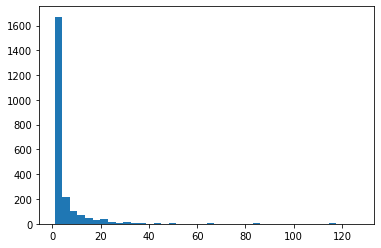

In [ ]:
"""
...and the great majority of keywords appear in less than 10 paragraphs.
"""

counts = []
for _, v in keyword_dict.items():
  counts.append(len(v))

plt.hist(counts, bins=40)

In [ ]:
"""
Function that returns paragraphs identified by their index and ordered by the contained number of question keywords.
top_paragraphs is what we need to answer the user's question, but return sorted_paragraph_tuples is returned as well for debugging.
"""

def get_context_candidates(paragraph, keyword_dict, spacy_model):
  words = simple_tokens([paragraph], spacy_model)

  paragraph_occurences = {}
  for w in words[0]:
    if w in keyword_dict:
      for idx in keyword_dict[w]:
        if idx in paragraph_occurences:
          paragraph_occurences[idx] += 1
        else:
          paragraph_occurences[idx] = 1
  
  sorted_paragraphs_tuples = sorted(paragraph_occurences.items(), key=lambda item: item[1], reverse=True)
  min_hits = sorted_paragraphs_tuples[0][1] - 1          # Only want contexts that contain most hits with question
  top_paragraphs = [p[0] for p in sorted_paragraphs_tuples if p[1] >= min_hits]

  return top_paragraphs, sorted_paragraphs_tuples

In [ ]:
top_paragraphs, sorted_paragraphs_tuples = get_context_candidates("What is a card's thrust triangle?", keyword_dict, spacy_model)
print(sorted_paragraphs_tuples)
print(top_paragraphs)

[(18, 3), (23, 3), (29, 3), (554, 3), (107, 3), (190, 3), (509, 3), (528, 2), (670, 2), (201, 2), (220, 2), (267, 2), (371, 2), (17, 2), (530, 2), (96, 2), (133, 2), (182, 2), (194, 2), (195, 2), (203, 2), (713, 2), (206, 2), (729, 2), (218, 2), (221, 2), (238, 2), (256, 2), (261, 2), (372, 2), (393, 2), (397, 2), (399, 2), (400, 2), (401, 2), (444, 2), (514, 1), (7, 1), (14, 1), (19, 1), (21, 1), (22, 1), (24, 1), (533, 1), (534, 1), (537, 1), (544, 1), (549, 1), (555, 1), (561, 1), (53, 1), (565, 1), (62, 1), (77, 1), (591, 1), (82, 1), (599, 1), (605, 1), (95, 1), (615, 1), (106, 1), (108, 1), (618, 1), (110, 1), (619, 1), (622, 1), (628, 1), (629, 1), (651, 1), (652, 1), (144, 1), (656, 1), (163, 1), (688, 1), (697, 1), (186, 1), (705, 1), (708, 1), (722, 1), (736, 1), (737, 1), (244, 1), (245, 1), (762, 1), (767, 1), (775, 1), (266, 1), (782, 1), (276, 1), (280, 1), (282, 1), (283, 1), (284, 1), (285, 1), (286, 1), (287, 1), (288, 1), (290, 1), (293, 1), (296, 1), (297, 1), (299, 

## Putting It All Together
We have several examples below (see test_combos) and see that the whole thing doesn't quite work perfectly... yet. The model whose encoders are fine-tuned (and overfitted) on our game rules yield better answers than the untuned model, but not the correct answer all the time.

I think there is much more to explore, which I look forward to continuing. The next step I'm thinking of is training the QA head on SQaAD v2 so that we better learn when no answer exists.

In [ ]:
question = 'What size is the thrust modifier cards in the neptune zone receive if they get a push?'
context_idxs, _ = get_context_candidates(question, keyword_dict, spacy_model)
contexts = [f_headsMerged[i] for i in context_idxs]
answer, score, context = question_all(question1, contexts, qa_untuned_pipe)
print(answer)
print(score)
print(context)

modified per H3c
0.1825813502073288
Solar-Powered Card is one with the solar icon (B2e). If a thruster or thruster support is solar-powered, the thrust is modified per H3c. Solar-powered cards are non-operational in the Neptune J Heliocentric Zone (labeled "NO SOLAR POWER") unless getting a push from a Powersat (-6 thrust). Solar-powered cards cannot be used in the Jupiter zone or beyond when anchoring a Bernal (2A5), unless getting a push from a Powersat. 


In [ ]:
test_combos = [
               (question1, target1, qa_untuned_pipe, 'untuned'),
               (question1, target1, qa_tuned_pipe, 'tuned'),
               (question2, target2, qa_untuned_pipe, 'untuned'),
               (question2, target2, qa_tuned_pipe, 'tuned'),
               (question3, target3, qa_untuned_pipe, 'untuned'),
               (question3, target3, qa_tuned_pipe, 'tuned'),
               (question4a, target4, qa_untuned_pipe, 'untuned'),
               (question4a, target4, qa_tuned_pipe, 'tuned'),
               (question4b, target4, qa_untuned_pipe, 'untuned'),
               (question4b, target4, qa_tuned_pipe, 'tuned'),
               (question5, target5, qa_untuned_pipe, 'untuned'),
               (question5, target5, qa_tuned_pipe, 'tuned')
]

prev_question = ''
for question, target, pipeline, label in test_combos:
  context_idxs, _ = get_context_candidates(question, keyword_dict, spacy_model)
  contexts = [f_headsMerged[i] for i in context_idxs]
  answer, score, context = question_all(question, contexts, pipeline)
  if question != prev_question:
    print()
    print(f'{question}  CORRECT ANS: {target}')
    prev_question = question
  print(f'{label} answer: {answer}  --> {score:.2%}')
  print(f'  {context}')


What does the Thrust Triangle color indicate?  CORRECT ANS: fuel grade
untuned answer: movement-modifying supports  --> 48.99%
  i. Wrench Icons indicate movement-modifying supports ( J5). These modifiers apply only if the card is part of the support chain (J1c) for an activated thrust triangle.
tuned answer: movement-modifying supports  --> 60.34%
  i. Wrench Icons indicate movement-modifying supports ( J5). These modifiers apply only if the card is part of the support chain (J1c) for an activated thrust triangle.

What color is the sky?  CORRECT ANS: blue
untuned answer: F4b  --> 88.43%
  d. Fueling & Wet Mass Chit. When first created, a Rocket’s tanks are empty. Indicate this by selecting a Wet Mass Chit of the same color (F4b) as the Spacecraft's thrust triangle and placing it on top of your Dry Mass Chit. If you wish to immediately add Fuel to your Rocket, either by cargo transfer (G1) or site refuel (I5), move the Wet Mass Chit to the right per (F3b)
tuned answer: color  --> 99.